# Deep Learning with Python - Chapter 3

In [21]:
from keras import models, layers
from keras.datasets import imdb
import matplotlib.pyplot as plt
import numpy as np

## Setup training data

Let's load the IMDB data.

The argument num_words=10000 means you’ll only keep the top 10,000 most frequently occurring words in the training data. Rare words will be discarded.

In [2]:
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

17465344/17464789 [==============================] - 4s 0us/step


To decode a review from numbers to english.

Indices are offset by 3 because 0, 1, and 2 are reserved indices for “padding,” “start ofsequence,” and “unknown.”

In [6]:
def decode_review():
    word_index         = imdb.get_word_index()
    reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
    decoded_review     = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])
    return decoded_review

We need to turn the word lists into tensors. We chose to do it the following way:

One-hot encode your lists to turn them into vectors of 0s and 1s. This would mean, for instance, turning the sequence `[3, 5]` into a 10,000-dimensional vector that would be all 0s except for indices 3 and 5, which would be 1s. Then you
could use as the first layer in your network a Dense layer, capable of handling floating-point vector data.

In [10]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

array([0., 1., 1., ..., 0., 0., 0.])

In [11]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

We also need to vectorize the labels

In [12]:
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

## Define the network

Now we define our network.

> In chapter 4, you’ll learn formal principles to guide you in making these choices.
> For the time being, you’ll have to trust me with the following architecture choice:
> - Two intermediate layers with 16 hidden units each
> - A third layer that will output the scalar prediction regarding the sentiment of the current review

- `relu` zeroes negative values
- `sigmoid` squashes values between 0 and 1

In [14]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

> Finally, you need to choose a loss function and an optimizer.
>
> Because you’re facing a binary classification problem and the output of your network is a probability
> (you end your network with a single-unit layer with a sigmoid activation),
> it’s best to use the binary_crossentropy loss. It isn’t the only viable choice: you could use, for instance,
> mean_squared_error.
>
> But crossentropy is usually the best choice when you’re dealing with models that output probabilities.
> Crossentropy is a quantity from the field of Information Theory that measures the distance between probability distributions or, in this case, between the ground-truth distribution and your predictions.

In [15]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

## Run the network

Use a subset of the training data to validate the experiment.

In [16]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

In [17]:
history = model.fit(
    partial_x_train,
    partial_y_train,
    epochs=20,
    batch_size=512,
    validation_data=(x_val, y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 3s 171us/step - loss: 0.5099 - acc: 0.7801 - val_loss: 0.3829 - val_acc: 0.8674
Epoch 2/20
15000/15000 [==============================] - 2s 136us/step - loss: 0.3012 - acc: 0.9041 - val_loss: 0.2996 - val_acc: 0.8909
Epoch 3/20
15000/15000 [==============================] - 2s 147us/step - loss: 0.2160 - acc: 0.9285 - val_loss: 0.3092 - val_acc: 0.8713
Epoch 4/20
15000/15000 [==============================] - 2s 138us/step - loss: 0.1725 - acc: 0.9440 - val_loss: 0.2834 - val_acc: 0.8848
Epoch 5/20
15000/15000 [==============================] - 2s 139us/step - loss: 0.1391 - acc: 0.9555 - val_loss: 0.2859 - val_acc: 0.8870
Epoch 6/20
15000/15000 [==============================] - 2s 126us/step - loss: 0.1113 - acc: 0.9663 - val_loss: 0.3082 - val_acc: 0.8817
Epoch 7/20
15000/15000 [==============================] - 2s 124us/step - loss: 0.0931 - acc: 0.9724 - val_loss: 0.3171 - 

Let's plot the training data to see what is happening.

> As you can see, the training loss decreases with every epoch, and the training accuracy
increases with every epoch. That’s what you would expect when running gradientdescent
optimization—the quantity you’re trying to minimize should be less with
every iteration.

> But that isn’t the case for the validation loss and accuracy: they seem to
peak at the fourth epoch. This is an example of what we warned against earlier: a
model that performs better on the training data isn’t necessarily a model that will do
better on data it has never seen before.

> In precise terms, what you’re seeing is overfitting:
after the second epoch, you’re overoptimizing on the training data, and you end
up learning representations that are specific to the training data and don’t generalize
to data outside of the training set.

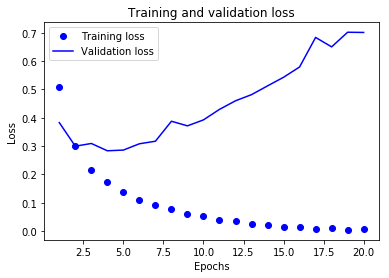

In [23]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['acc']) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

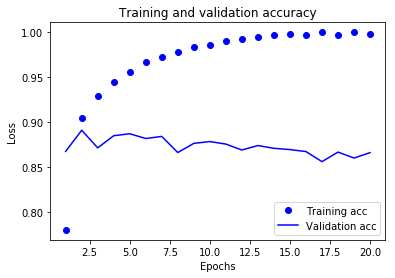

In [25]:
plt.clf()
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Let's re-train a network running with fewer epochs to see the result with less overfitting.

> This fairly naive approach achieves an accuracy of 88%. With state-of-the-art approaches, you should be able to get close to 95%.

In [27]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)

results

Epoch 1/4
25000/25000 [==============================] - 2s 96us/step - loss: 0.4750 - acc: 0.8218
Epoch 2/4
25000/25000 [==============================] - 2s 89us/step - loss: 0.2655 - acc: 0.9098
Epoch 3/4
25000/25000 [==============================] - 2s 91us/step - loss: 0.1983 - acc: 0.9299
Epoch 4/4
25000/25000 [==============================] - 2s 73us/step


[0.32278433185577393, 0.87308]

## Using a trained network to generate predictions on new data

> As you can see, the network is confident for some samples (0.99 or more, or 0.01 or
less) but less confident for others (0.6, 0.4).

In [29]:
model.predict(x_test)

array([[0.13802871],
       [0.9996977 ],
       [0.30465105],
       ...,
       [0.07149828],
       [0.04362256],
       [0.47474465]], dtype=float32)

# Exercises

> The following experiments will help convince you that the architecture choices you’ve made are all fairly reasonable, although there’s still room for improvement:
> - You used two hidden layers. Try using one or three hidden layers, and see how doing so affects validation and test accuracy.
> - Try using layers with more hidden units or fewer hidden units: 32 units, 64 units, and so on.
> - Try using the mse loss function instead of binary_crossentropy.
> - Try using the tanh activation (an activation that was popular in the early days of neural networks) instead of relu.